In [2]:
import os
# training area of DC1 SKA simulated Map. Compare position of sources in the original map and the recovered map, And Flux recovery.
PATH_SKADC1_TRAINING = '/Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3_cropped.fits'
PATH_SKADC1_FULL = '/Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3.fits'
# function to test if the file exists
def file_exists(path):
    if os.path.isfile(path):
        print('File exists : '+path)
        return True
    else:
        print('File does not exist : '+path)
        return False
    

file_exists(PATH_SKADC1_TRAINING)
file_exists(PATH_SKADC1_FULL)

File exists : /Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3_cropped.fits
File exists : /Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3.fits


True

   
###########################
 _____   ___    ___    ___ 
|_   _| | _ \  / __|  | __|
  | |   |   /  \__ \  | _| 
  |_|   |_|_\  |___/  |_|  
        
###########################
Topological Radio Source Finder.
        
-------------------
Starting TRSF
NOTICE: Image path: /Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3_cropped.fits
Attempting to open Image...
NOTICE: Input Image Size (3198, 3490)
NOTICE: Image Size with reduced padding (3198, 3490)
Calculating persistence diagrams and source properties..


Cutouts Completed: 100%|██████████| 182/182 [08:54<00:00,  2.94s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


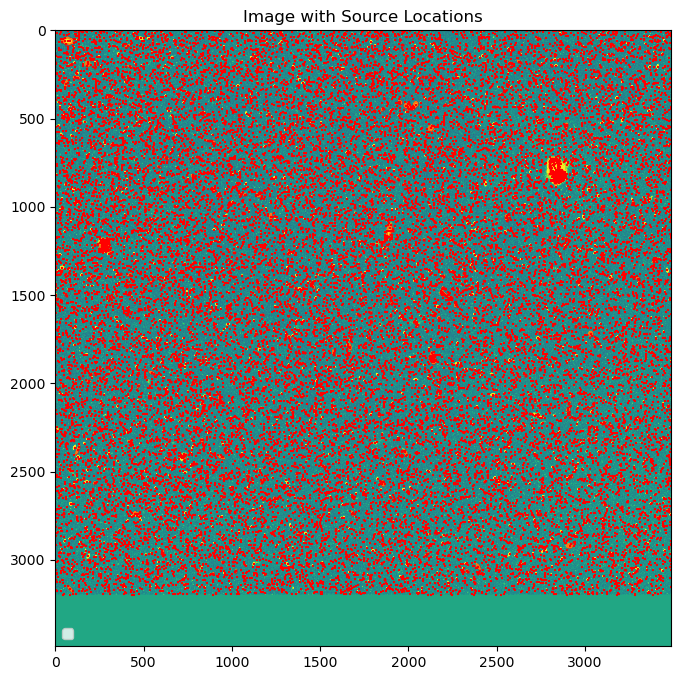

TRSF finished.
Time taken: 537.2139658927917 seconds
-------------------


In [3]:
from TRSF import trsf
import numpy as np 
import matplotlib.pyplot as plt

SKA_DC1_TRSF = trsf(PATH_SKADC1_TRAINING)

In [4]:
from astropy.stats import mad_std

print(len(SKA_DC1_TRSF.catalogue))
local_bg = mad_std(SKA_DC1_TRSF.full_img, ignore_nan=True)
print('local_bg', local_bg)

28527
local_bg 3.4864351509170494e-07


In [5]:
import skimage.measure as measure

def get_enclosing_mask(x, y, mask):
    '''
    Returns the mask of the enclosed area of the point (x,y) in the mask.
    '''
    
    # Ensure the point is inside the mask
    if not mask[y, x]:
        return None
    # Create a copy of the mask
    enclosed_mask = np.copy(mask)
    # Perform a flood fill starting from the point
    h, w = mask.shape
    stack = [(x, y)]
    while stack:
        x, y = stack.pop()
        if enclosed_mask[y, x]:
            enclosed_mask[y, x] = False
            if x > 0:
                stack.append((x - 1, y))
            if x < w - 1:
                stack.append((x + 1, y))
            if y > 0:
                stack.append((x, y - 1))
            if y < h - 1:
                stack.append((x, y + 1))
    
    return mask & (~enclosed_mask)

def plottings(cat,ptype,color,img,row=False):
    
    label = False
    for i in range(0,len(cat)):
        row = cat.iloc[i]
        if ptype=='bbox':
            bbox = row.bbox
            if bbox != None:
                xmin = bbox[0] - 1
                xmax = bbox[2] + 1
                ymin = bbox[1] - 1
                ymax = bbox[3] + 1
                if label == False:
                    plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color=color,label='class 5')
                    label = True
                plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color=color)
        if ptype == 'point':
            plt.plot(row.y,row.x,'+',color=color)
        
        if ptype == 'polygonwith':
            polygon = row.polygon
            try:
                if label == False:
                    plt.plot(polygon[:,1],polygon[:,0],color=color,label='class 2')
                    label = True
                else:
                    plt.plot(polygon[:,1],polygon[:,0],color=color)  
            except:
                #print('polygonwith Failed')
                continue
                #plottings(cat,'polygonwithout',color,img) 
                
        if ptype == 'polygonwithout':
        # we much create the polygons from the birth and death points
            try:
                birth = row.Birth
                death = row.Death
                mask = np.zeros(img.shape)
                mask = np.logical_or(mask, np.logical_and(img <= birth, img > death))
                #print(row.x_c,row.y_c)
                
                mask = get_enclosing_mask(int(row.x_c),int(row.y_c),mask)
                mask = mask.astype(int)

                contour = measure.find_contours(mask)[0]

                if label == False:
                    plt.plot(contour[:,1],contour[:,0],color=color,label='class 2')
                    label= True
                else:
                    plt.plot(contour[:,1],contour[:,0],color=color)   
            except:
                print(row)

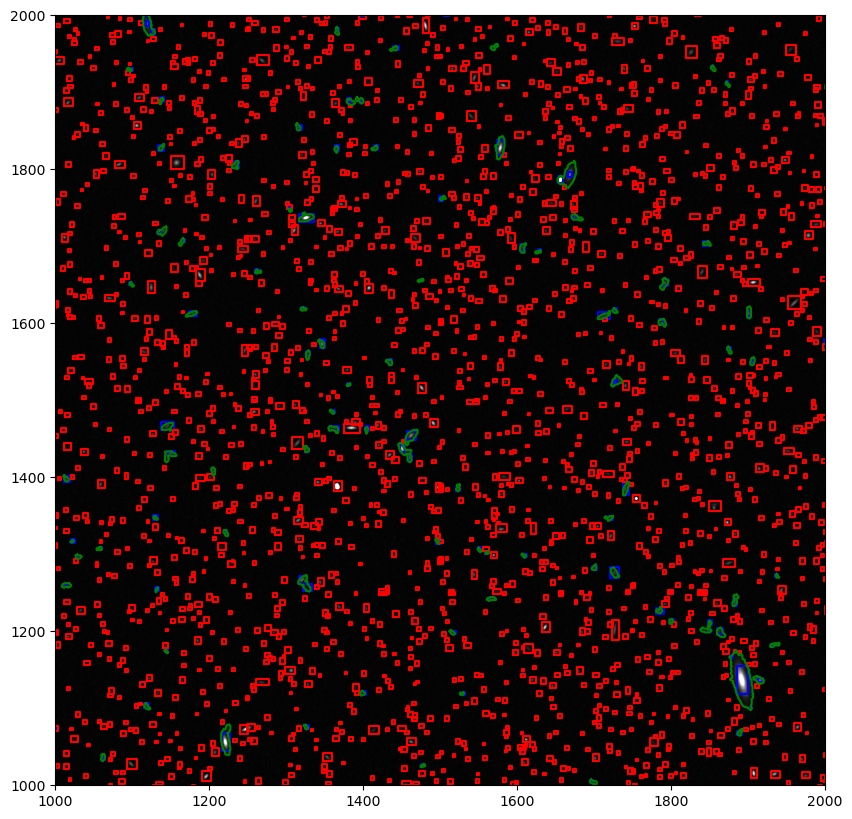

In [6]:
image = SKA_DC1_TRSF.full_img
catalogue = SKA_DC1_TRSF.catalogue
catalogue['Class'][np.isnan(catalogue['Class'])] = 2
cat0 = catalogue[catalogue['Class'] == 0]
cat1 = catalogue[catalogue['Class'] == 1]
cat2 = catalogue[catalogue['Class'] == 2]
cat3 = catalogue[catalogue['Class'] == 3]
cat4 = catalogue[catalogue['Class'] == 4]
cat5 = catalogue[catalogue['Class'] == 5]
plt.figure(figsize=(10,10))
plt.imshow(image,origin='lower',cmap='gray',vmax=0.0001)
plottings(cat5,'bbox',color='b',img=image)
plottings(cat1,'bbox',color='r',img=image)
plottings(cat2,'polygonwith',color='g',img=image)
plottings(cat3,'bbox',color='y',img=image)
#plottings(cat4,'polygonwithout',color='m',img=image)
#plottings(cat5,'polygonwithout',color='c',img=image)
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

In [34]:
# open training data
PATH_training_SKA = '/Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/TrainingSet_B1_v2.txt'

# open txt. file where elements are separated by a different number of spaces
import pandas as pd

training_catalogue = pd.read_csv(PATH_training_SKA, sep='\s+', header=None)
# drop the first row
training_catalogue = training_catalogue.drop([0], axis=0)
# drop last 5 columns
training_catalogue = training_catalogue.drop([15,16,17,18,19], axis=1)
# rename columns
training_catalogue.columns = ['ID','RA_core','DEC_core','RA_centroid','DEC_centroid','FLUX_Tot_corr','Core_Frac','BMAJ','BMIN','PA','SIZE','CLASS','SELECTION','x','y']
# set correct datatypes to catalogue

training_catalogue['ID'] = training_catalogue['ID'].astype('int')
training_catalogue['RA_core'] = training_catalogue['RA_core'].astype('float')
training_catalogue['DEC_core'] = training_catalogue['DEC_core'].astype('float')
training_catalogue['RA_centroid'] = training_catalogue['RA_centroid'].astype('float')
training_catalogue['DEC_centroid'] = training_catalogue['DEC_centroid'].astype('float')
training_catalogue['FLUX_Tot_corr'] = training_catalogue['FLUX_Tot_corr'].astype('float')
training_catalogue['Core_Frac'] = training_catalogue['Core_Frac'].astype('float')
training_catalogue['BMAJ'] = training_catalogue['BMAJ'].astype('float')
training_catalogue['BMIN'] = training_catalogue['BMIN'].astype('float')
training_catalogue['PA'] = training_catalogue['PA'].astype('float')
training_catalogue['SIZE'] = training_catalogue['SIZE'].astype('float')
training_catalogue['CLASS'] = training_catalogue['CLASS'].astype('int')
training_catalogue['SELECTION'] = training_catalogue['SELECTION'].astype('int')
training_catalogue['x'] = training_catalogue['x'].astype('float')
training_catalogue['y'] = training_catalogue['y'].astype('float')

from astropy.io import fits

def convert_arcsec_to_pixels(Image_PATH,spacial_width,header=None):
    '''Convert arcsec widths to pixels numbers.'''
    # Load the image header
    if header == None:
        print('Loading the image header')
        header = fits.open(Image_PATH)[0].header
    else:
        print('Using the provided header')
        header = header
    # Read the header parameters
    arcseconds_per_pixel = header['CDELT1']*3600*-1
    beam_size_arcseconds = header['BMAJ']*3600
    print(type(spacial_width))
    print(beam_size_arcseconds)
    oversampled_spacial_width = (spacial_width**2 + beam_size_arcseconds**2)**0.5
    return oversampled_spacial_width/arcseconds_per_pixel

training_catalogue['BMAJ_p'] = convert_arcsec_to_pixels(PATH_SKADC1_TRAINING,training_catalogue['BMAJ'])
training_catalogue['BMIN_p'] = convert_arcsec_to_pixels(PATH_SKADC1_TRAINING,training_catalogue['BMIN'])
# remove source with total flux less than detection threshold.
detect_thresh = local_bg
print('Detection threshold: ',detect_thresh)
training_catalogue = training_catalogue[training_catalogue['FLUX_Tot_corr'] > detect_thresh]
# surface brightness cutouff 

# drop where selection =0  (no selection)
#training_catalogue[training_catalogue['SELECTION'] == 1]
# alter x an y to be normalized by the min and max of the catalogue
min_x = int(training_catalogue['x'].min())
max_x = int(training_catalogue['x'].max())
min_y = int(training_catalogue['y'].min())
max_y = int(training_catalogue['y'].max())

training_catalogue['x'] = training_catalogue['x'] - min_x
training_catalogue['y'] = training_catalogue['y'] - min_y

def area(maj,min):
    # area of ellipse
    return np.pi*maj*min

training_catalogue['AREA_p'] = area(training_catalogue['BMAJ_p'],training_catalogue['BMIN_p']) 

Loading the image header
<class 'pandas.core.series.Series'>
1.5000000363216
Loading the image header
<class 'pandas.core.series.Series'>
1.5000000363216
Detection threshold:  3.4864351509170494e-07


(3490, 3490)


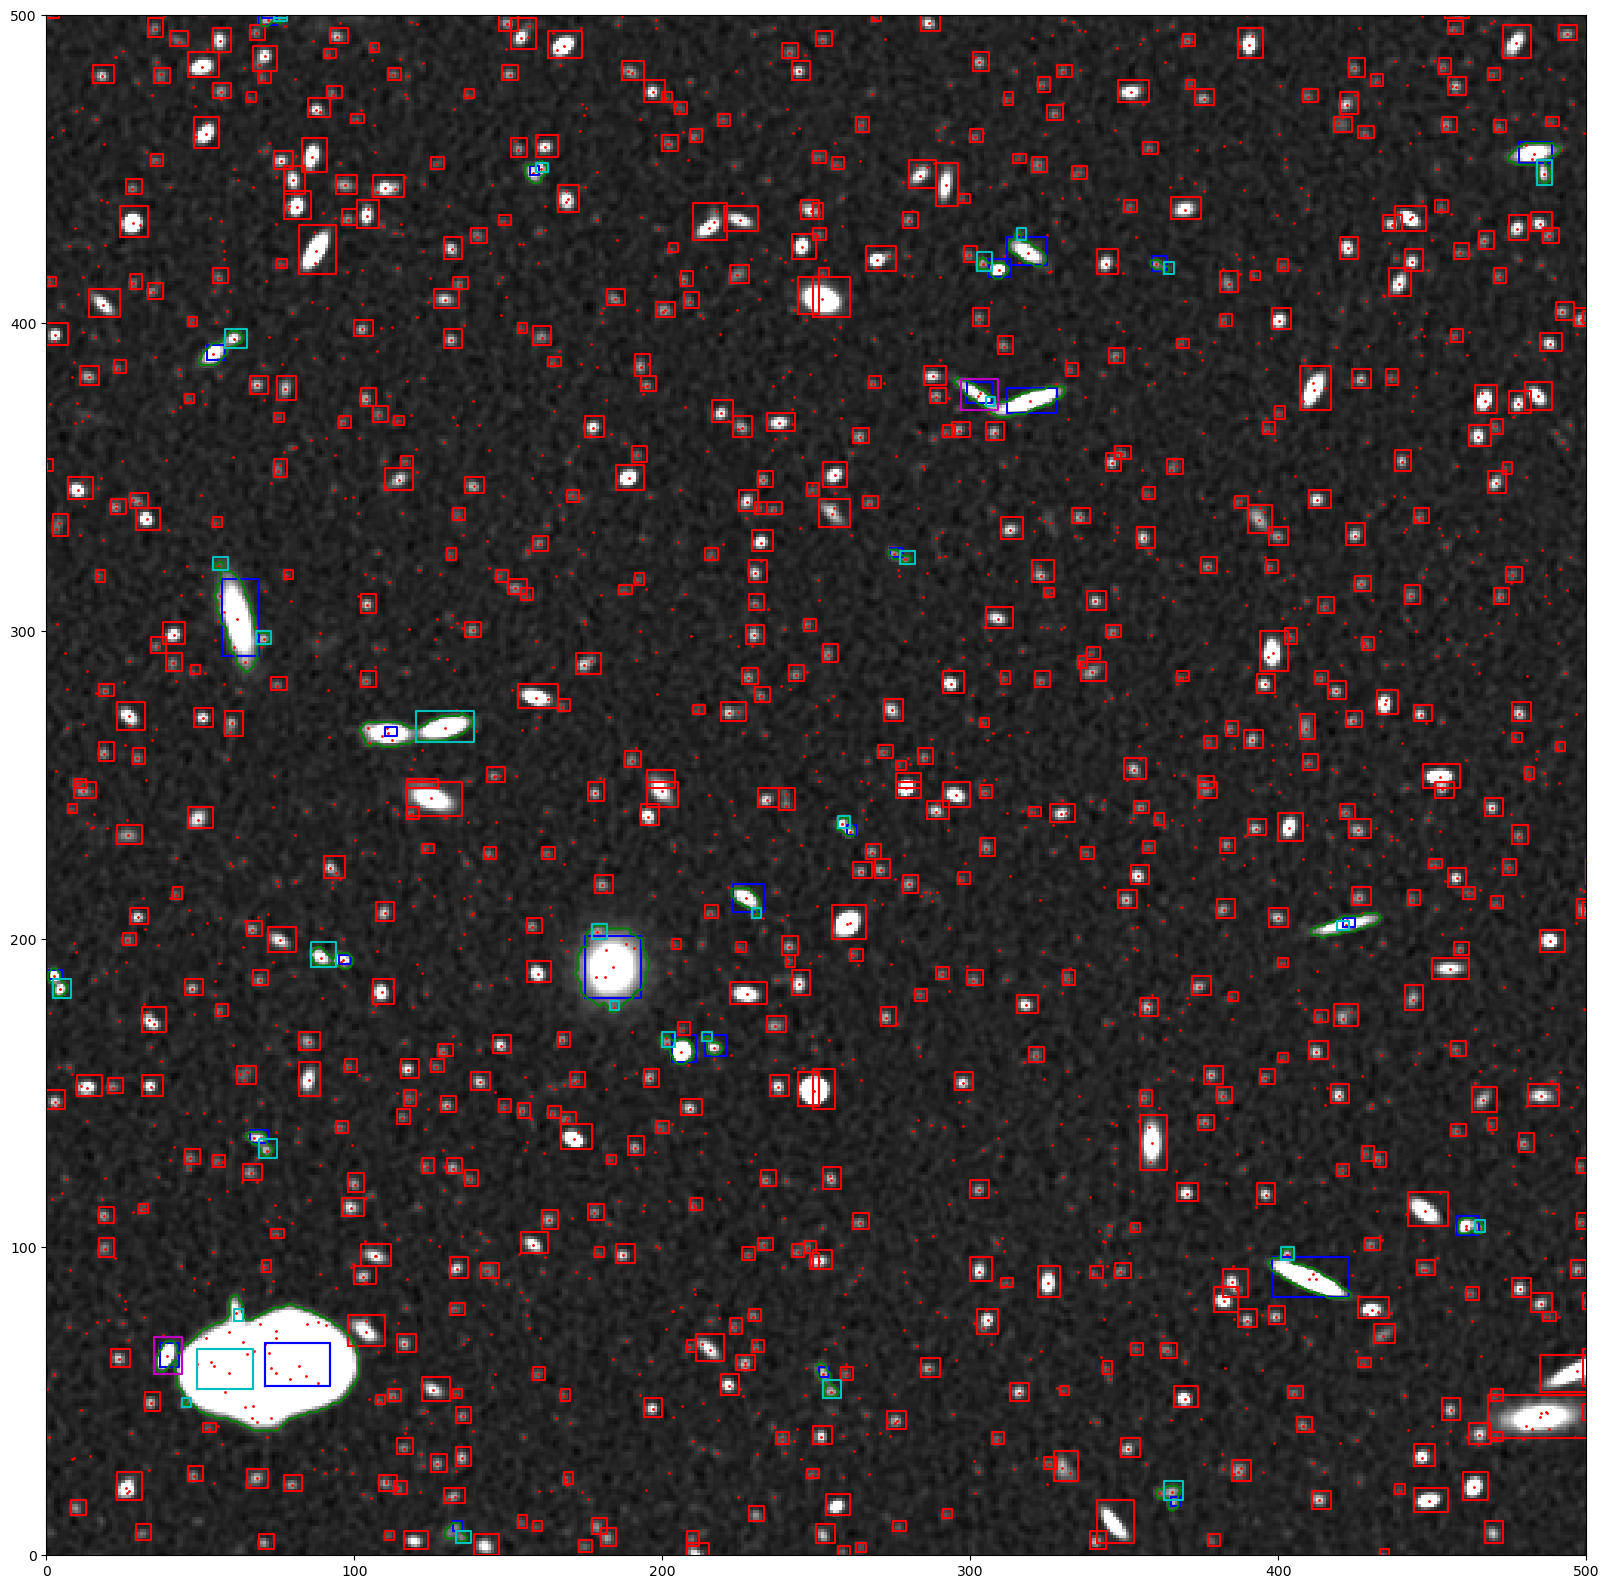

In [8]:
from matplotlib.patches import Ellipse

print(SKA_DC1_TRSF.full_img.shape)
plt.figure(figsize=(20,20))
plt.imshow(SKA_DC1_TRSF.full_img, cmap='gray',vmax=0.00001,origin='lower')
plt.scatter(x=training_catalogue.x, y=training_catalogue.y, c='r', s=1)
plottings(cat5,'bbox',color='b',img=image)
plottings(cat1,'bbox',color='r',img=image)
plottings(cat2,'polygonwith',color='g',img=image)
plottings(cat3,'bbox',color='y',img=image)
plottings(cat4,'bbox',color='m',img=image)
plottings(cat0,'bbox',color='c',img=image)
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()

In [24]:
# create unique id for each row thats not the index
listnums = np.arange(0, len(catalogue),1)

catalogue['id'] = listnums
catalogue.value_counts('id')

id
0        1
19014    1
19025    1
19024    1
19023    1
        ..
9505     1
9504     1
9503     1
9502     1
28526    1
Length: 28527, dtype: int64

In [58]:
from tqdm import tqdm

matched_catalogue = training_catalogue.copy()
matched_catalogue['matched_ids'] = np.nan
matched_catalogue['dist'] = np.nan
radius = 5

# matching of sources.
for i in tqdm(range(0,len(catalogue)),total=len(catalogue),desc='Matching sources'):
    row = catalogue.iloc[i]
    tag = row.id

    matched_catalogue_cropped = matched_catalogue.copy()
    matched_catalogue_cropped = matched_catalogue_cropped[
        (matched_catalogue_cropped.x > row.x_c - 25) & 
        (matched_catalogue_cropped.x < row.x_c + 25) & 
        (matched_catalogue_cropped.y > row.y_c - 25) & 
        (matched_catalogue_cropped.y < row.y_c + 25)]

    for i in range(len(matched_catalogue_cropped)):
        x = matched_catalogue_cropped.iloc[i].x
        y = matched_catalogue_cropped.iloc[i].y
        #s_p = np.mean([matched_catalogue_cropped.iloc[i].BMAJ_p,matched_catalogue_cropped.iloc[i].BMAJ_p])
        #s = row.area
        #dist_s = abs(s - matched_catalogue_cropped.iloc[i].AREA_p)/matched_catalogue_cropped.iloc[i].AREA_p
        dist = np.sqrt((row.x_c-x)**2 + (row.y_c-y)**2)
        
        if dist < radius:
            #if dist_s < 0.5:
            matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('matched_ids')] = tag
            matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('dist')] = dist
                        
            matched_catalogue.update(matched_catalogue_cropped,overwrite=False) # prevent double matching assignements. keep the first one.
                
      
            

Matching sources: 100%|██████████| 28527/28527 [06:44<00:00, 70.59it/s]


In [26]:
for i in range(0,1):
    tag = catalogue.iloc[i]['id']
    matched_catalogue_cropped = matched_catalogue[matched_catalogue.id == tag]
    print(matched_catalogue_cropped)
    if len(matched_catalogue_cropped) >= 2:
        # keep the one with the lowest dist
        matched_catalogue_cropped = matched_catalogue_cropped[matched_catalogue_cropped.dist == matched_catalogue_cropped.dist.min()]


AttributeError: 'DataFrame' object has no attribute 'id'

In [11]:

#matched_catalogue = training_catalogue.copy()
#matched_catalogue['matched_ids'] = np.nan
#matched_catalogue['dist'] = np.nan
#radius = 5
#i = 147
# matching of sources.
#row = cat1.iloc[i]
#tag = row.id
#print(tag)#
#matched_catalogue_cropped = matched_catalogue.copy()
#matched_catalogue_cropped = matched_catalogue_cropped[
#    (matched_catalogue_cropped.x > row.x_c - 25) & 
#    (matched_catalogue_cropped.x < row.x_c + 25) & 
#    (matched_catalogue_cropped.y > row.y_c - 25) & 
#    (matched_catalogue_cropped.y < row.y_c + 25)]


#for i in range(len(matched_catalogue_cropped)):
#    x = matched_catalogue_cropped.iloc[i].x
#    y = matched_catalogue_cropped.iloc[i].y
#    dist = np.sqrt((x-row.x_c)**2 + (y-row.y_c)**2)
    
#    if dist < radius:
#        print('match found')
#        matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('matched_ids')] = tag
#        matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('dist')] = dist
                    
#    matched_catalogue.update(matched_catalogue_cropped,overwrite=False)

# check if 0 index is in the list of matched ids
#if 0 not in matched_catalogue.matched_ids.values:
#    print('0 not in matched ids')

    

              ID   RA_core   DEC_core  RA_centroid  DEC_centroid  \
671     27514971 -0.014459 -29.933004    -0.014121    -29.932705   
11767   18008787 -0.014459 -29.933004    -0.014459    -29.933004   
136960  32663623 -0.014012 -29.931931    -0.014012    -29.931931   

        FLUX_Tot_corr  Core_Frac    BMAJ    BMIN       PA  SIZE  CLASS  \
671      3.932430e-02   0.004216  31.508  17.616  353.308   1.0      1   
11767    4.358480e-07   0.769257   0.010   0.010   24.288   2.0      2   
136960   9.721050e-07  -0.000000   0.463   0.267  -20.088   2.0      3   

        SELECTION       x       y     BMAJ_p     BMIN_p       AREA_p  \
671             1  72.911  60.927  52.203106  29.259033  4798.507514   
11767           1  74.651  59.143   2.482475   2.482475    19.360633   
136960          1  72.346  65.541   2.597986   2.521439    20.579518   

        matched_ids      dist  
671             1.0  1.992356  
11767           1.0  4.276277  
136960          1.0  4.475702  
    index  am

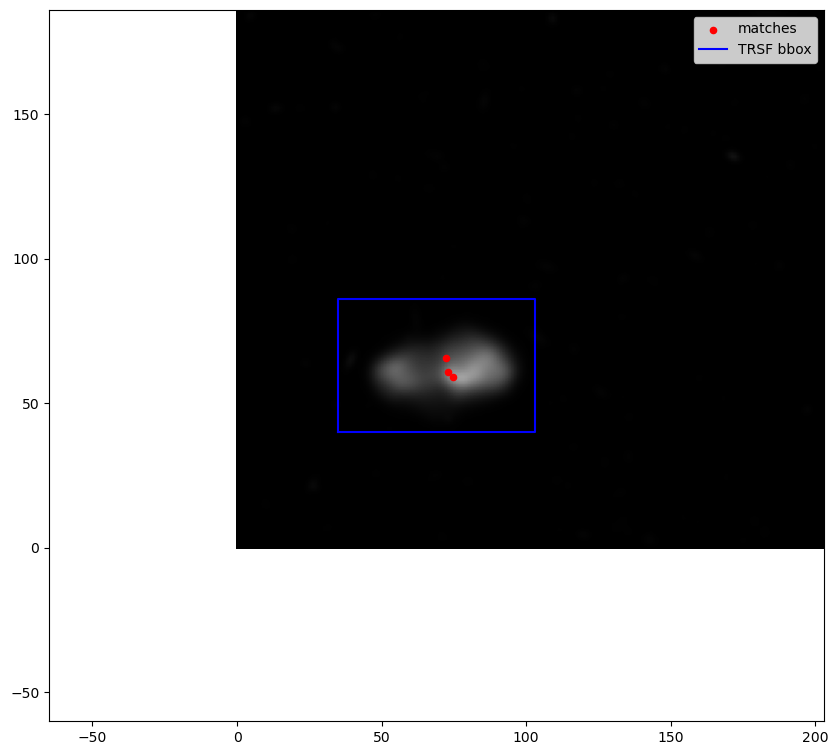

In [62]:
tag = 1
single_match = matched_catalogue[matched_catalogue['matched_ids']==tag]
print(single_match)
plt.figure(figsize=(10,10))
plt.imshow(SKA_DC1_TRSF.full_img, cmap='gray',vmax=0.001,origin='lower')
plt.scatter(single_match.x, single_match.y, c='r', s=20,label='matches')
bbox = catalogue[catalogue['id']==tag].bbox.values[0]
print(catalogue[catalogue['id']==tag])
print(bbox)
#if bbox != None:
xmin = bbox[0] - 1
xmax = bbox[2] + 1
ymin = bbox[1] - 1    
ymax = bbox[3] + 1
plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color='b',label='TRSF bbox')
plt.xlim(ymin-100, ymax+100)
plt.ylim(xmin-100, xmax+100)
plt.legend()
plt.show()

In [59]:
# calculate the number of matched sources in flux bins.
# flux Int tot | matched num | True num | matched num / True num


ssagn_matched_catalogue = matched_catalogue[matched_catalogue['CLASS'] == 1]
Flux_Truth_ssagn = ssagn_matched_catalogue['FLUX_Tot_corr'].to_numpy()
print(len(Flux_Truth_ssagn))
partial_matched_cat = ssagn_matched_catalogue.dropna()
Flux_matched_ssagn = partial_matched_cat['FLUX_Tot_corr'].to_numpy()
print(len(Flux_matched_ssagn))


fsagn_matched_catalogue = matched_catalogue[matched_catalogue['CLASS'] == 2]
Flux_Truth_fsagn = fsagn_matched_catalogue['FLUX_Tot_corr'].to_numpy()
print(len(Flux_Truth_fsagn))
partial_matched_cat = fsagn_matched_catalogue.dropna()
Flux_matched_fsagn = partial_matched_cat['FLUX_Tot_corr'].to_numpy()
print(len(Flux_matched_fsagn))

sfg_matched_catalogue = matched_catalogue[matched_catalogue['CLASS'] == 3]
Flux_Truth_sfg = sfg_matched_catalogue['FLUX_Tot_corr'].to_numpy()
print(len(Flux_Truth_sfg))
partial_matched_cat = sfg_matched_catalogue.dropna()
Flux_matched_sfg = partial_matched_cat['FLUX_Tot_corr'].to_numpy()
print(len(Flux_matched_sfg))

1648
542
1544
612
102550
39627


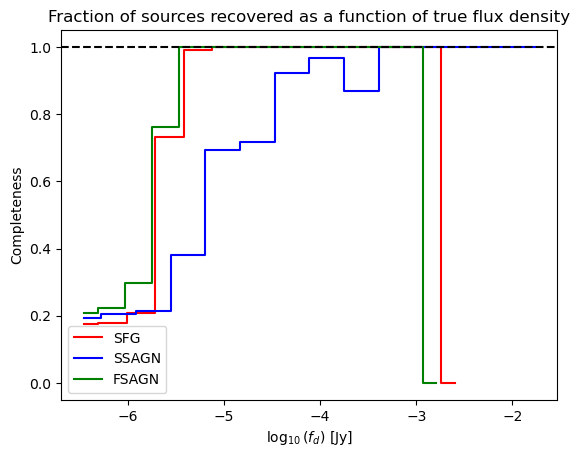

In [60]:
def hist_plot(Flux_Truth,Flux_matched):
    bins = np.linspace(np.log10(min(Flux_Truth)),np.log10(max(Flux_Truth)),15)
    # find the completeness of matched sources in each bin
    Completeness_list = []
    for i in range(len(bins)-1):
        # find indexes of flux densities within the bin
        index = (np.log10(Flux_Truth) > bins[i]) & (np.log10(Flux_Truth) < bins[i+1])
        
        number_of_expected_sources_in_bin = len(Flux_Truth[index])
        # find indexes of matched sources within the bin
        index = (np.log10(Flux_matched) > bins[i]) & (np.log10(Flux_matched) < bins[i+1])
        number_of_matched_source_in_bin = len(Flux_matched[index])
        # find the completeness of matched sources in the bin
        try:
            Completeness_list.append(number_of_matched_source_in_bin/number_of_expected_sources_in_bin)
        except ZeroDivisionError:
            Completeness_list.append(0)
    return Completeness_list, bins

sfg_Completeness_list, sfg_bins = hist_plot(Flux_Truth_sfg,Flux_matched_sfg)
ssagn_Completeness_list, ssagn_bins = hist_plot(Flux_Truth_ssagn,Flux_matched_ssagn)
fsagn_Completeness_list, fsagn_bins = hist_plot(Flux_Truth_fsagn,Flux_matched_fsagn)

plt.step(sfg_bins[:-1],sfg_Completeness_list,where='mid',color='red',label='SFG')
#plt.plot(sfg_bins[:-1],sfg_Completeness_list,color='red')
plt.step(ssagn_bins[:-1],ssagn_Completeness_list,where='mid',color='blue',label='SSAGN')
#plt.plot(ssagn_bins[:-1],ssagn_Completeness_list,color='blue')
plt.step(fsagn_bins[:-1],fsagn_Completeness_list,where='mid',color='green',label='FSAGN')
#plt.plot(fsagn_bins[:-1],fsagn_Completeness_list,color='green')
plt.title("Fraction of sources recovered as a function of true flux density")
plt.axhline(1,linestyle='--',color='black')
plt.xlabel('$\log_{10}(f_{d})$ [Jy]')
plt.ylabel('Completeness')
plt.legend()
plt.show()

In [21]:
print(len(catalogue))
print(len(matched_catalogue.dropna()))

28527
40781


In [15]:
# reliabilty is matches/detection per flux bin.
# look if there are any non detections, e.g. cats with no corresponding tag in the other cat





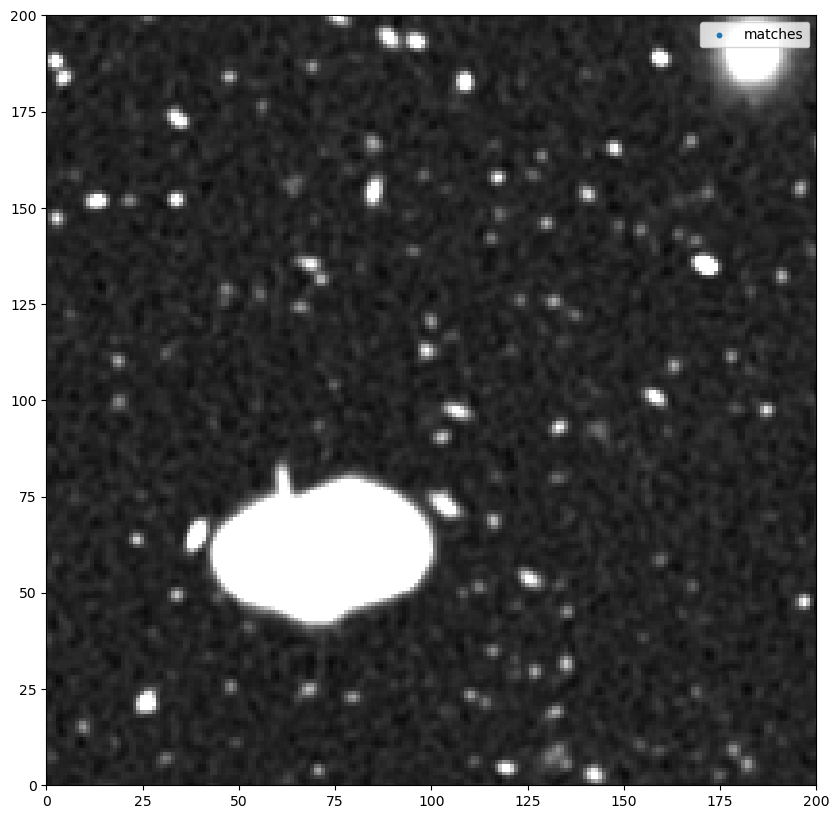

In [16]:
single_match = matched_catalogue[matched_catalogue['matched_ids']==2934]

plt.figure(figsize=(10,10))
plt.imshow(SKA_DC1_TRSF.full_img, cmap='gray',vmax=0.00001,origin='lower')
plt.scatter(single_match.x - min_x, single_match.y - min_y, s=10,label='matches')
bbox = row.bbox
if bbox != None:
    xmin = bbox[0] - 1
    xmax = bbox[2] + 1
    ymin = bbox[1] - 1
    ymax = bbox[3] + 1
    plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color='b',label='TRSF bbox')
plt.xlim(0,200)
plt.ylim(0,200)
plt.legend()
plt.show()

In [17]:
single_match

,ID,RA_core,DEC_core,RA_centroid,DEC_centroid,FLUX_Tot_corr,Core_Frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y,BMAJ_p,BMIN_p,matched_ids,dist
29457,4638522,-0.174077,-29.862917,-0.174077,-29.862917,3.493040e-07,-0.0,0.617,0.388,-79.224,2.0,3,1,899.409,476.032,2.684224,2.564122,2934.0,3.279320
40084,28738041,-0.173953,-29.862343,-0.173953,-29.862343,6.799310e-06,-0.0,0.929,0.371,44.903,2.0,3,1,898.775,479.453,2.919956,2.557222,2934.0,0.280374
